In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal','classification')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [6]:
mode = 'valence-arousal'

In [7]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('../Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


In [8]:
from KDEweightedMSE.losses import KDEWeightedMSESc

data = train_dataset.df[['valence', 'arousal']]

loss_fct = KDEWeightedMSESc(data=data, band_width=0.1, device=device)
kernel = loss_fct.kernel
kernel

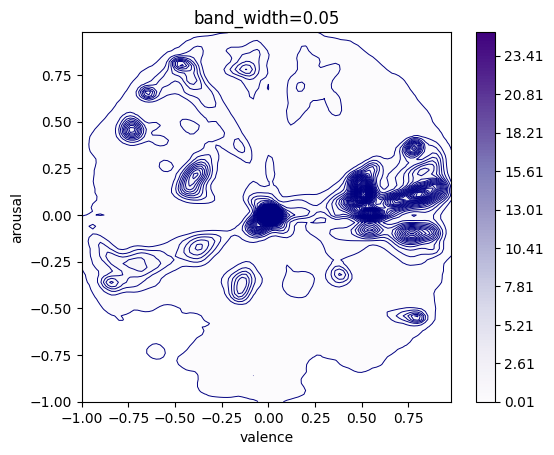

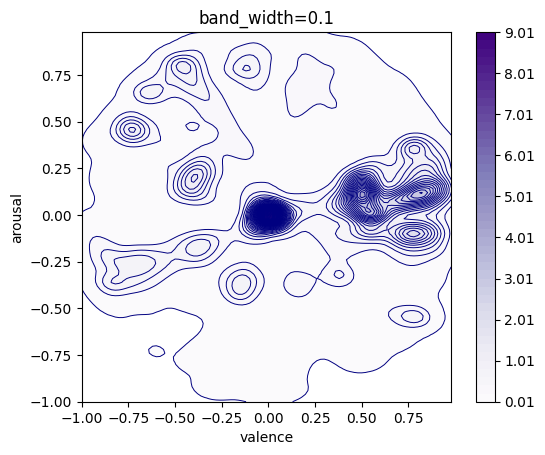

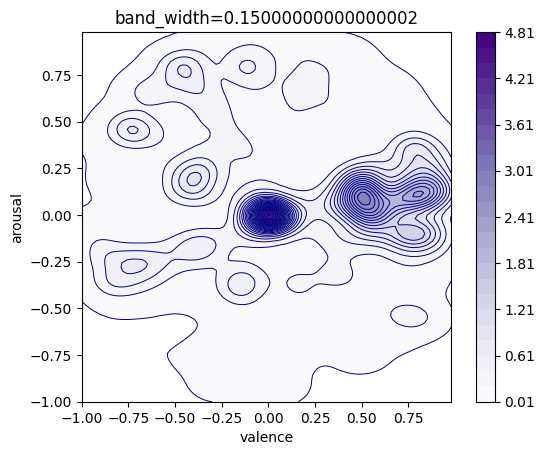

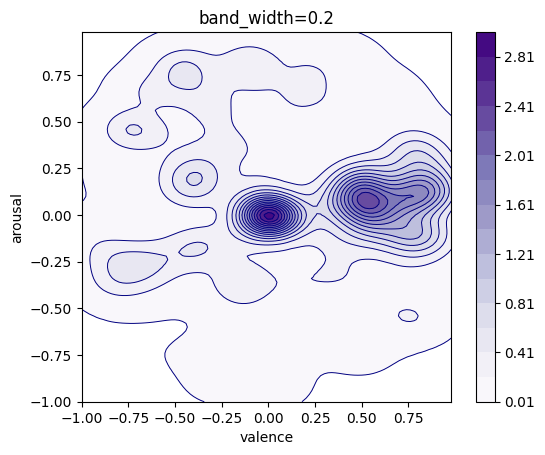

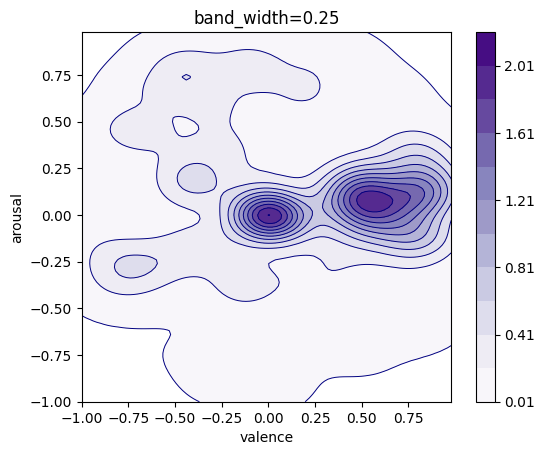

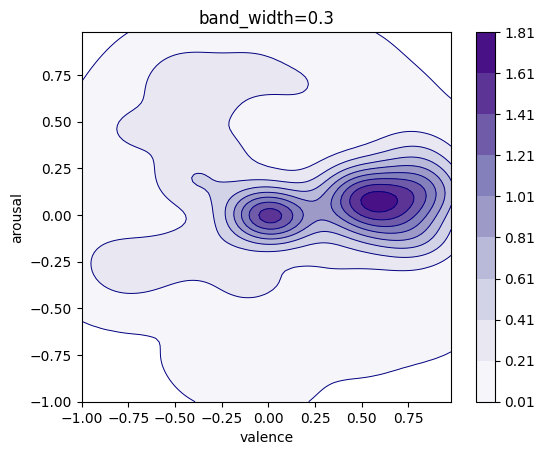

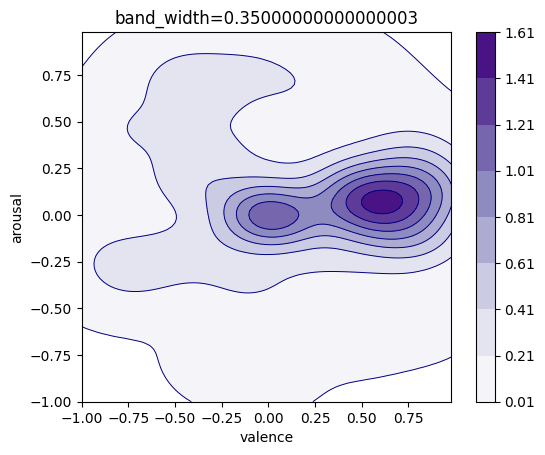

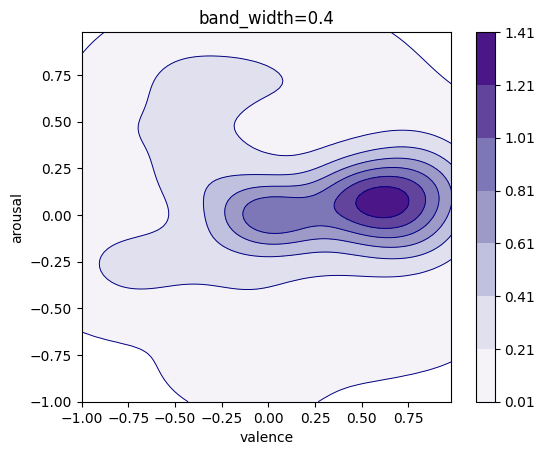

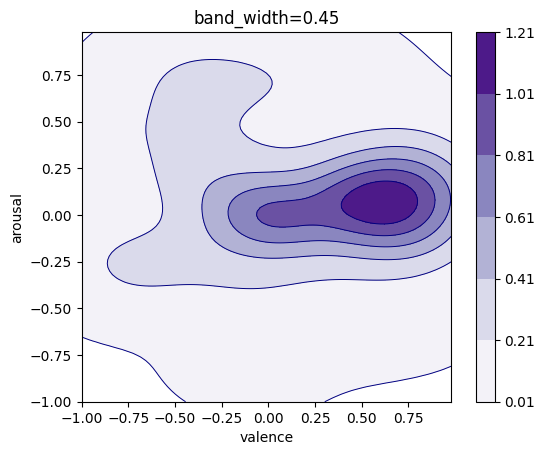

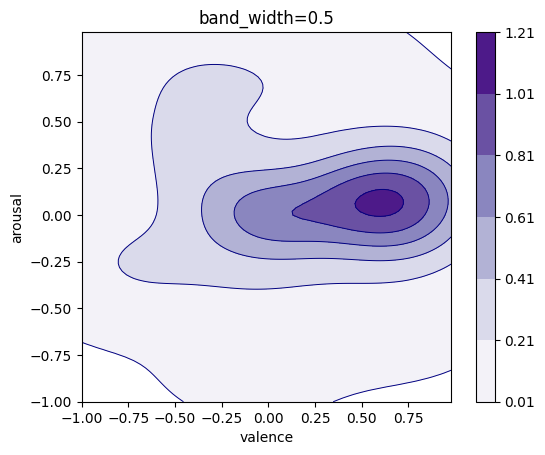

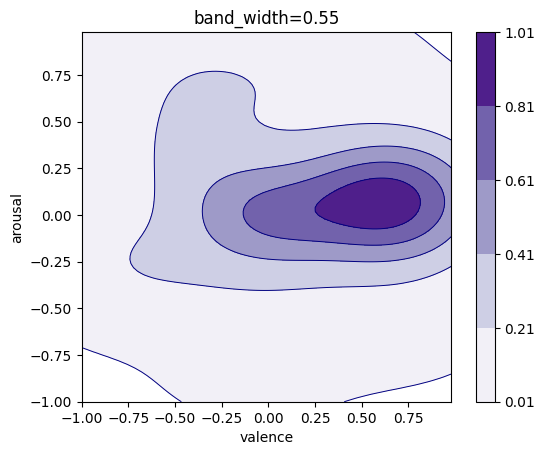

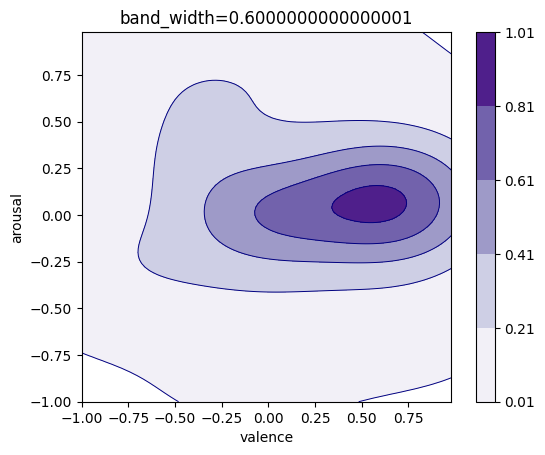

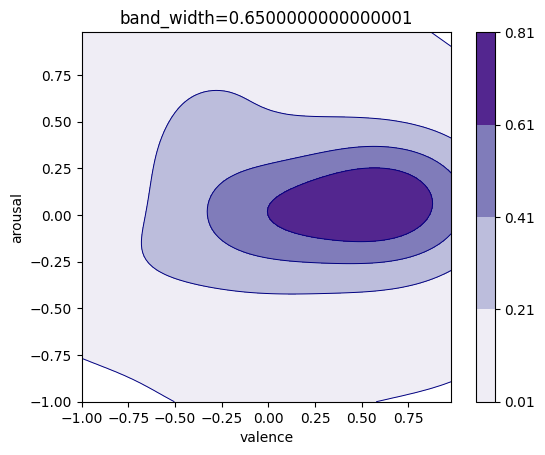

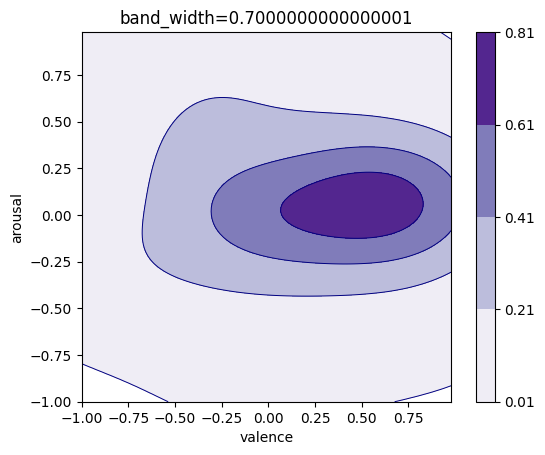

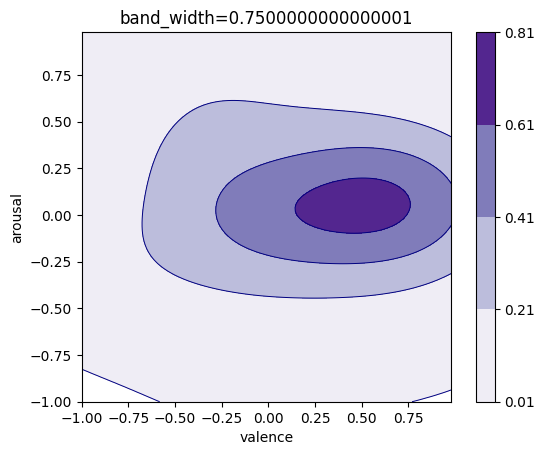

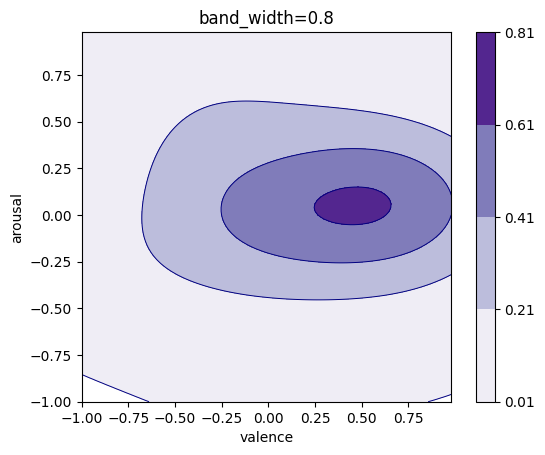

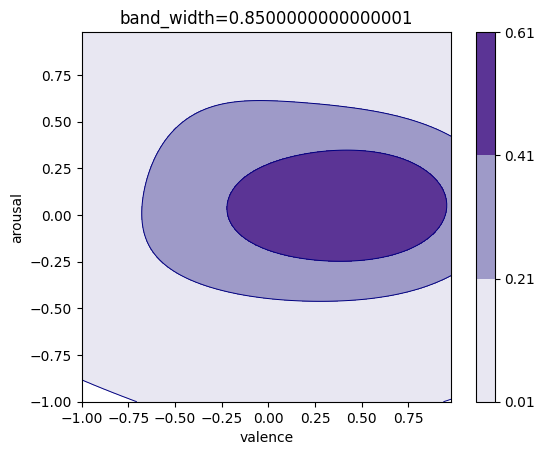

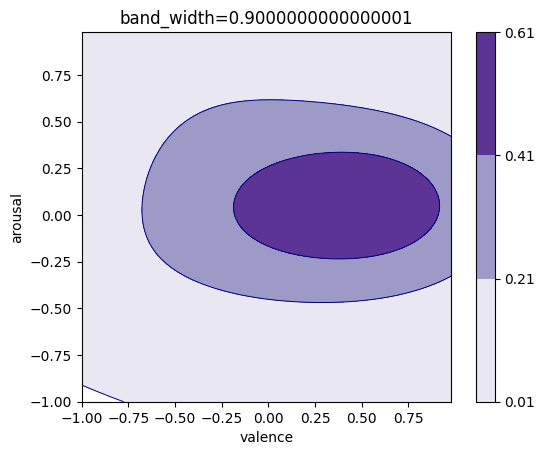

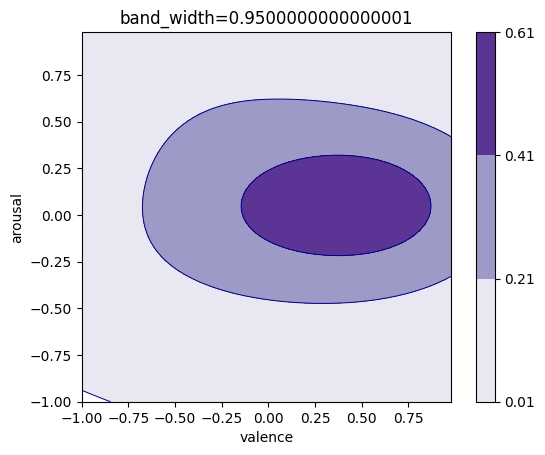

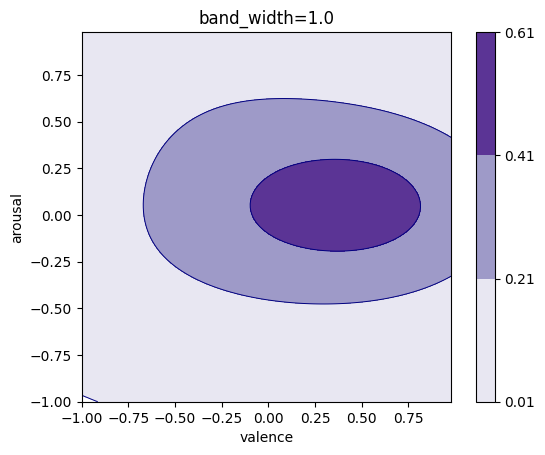

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as  cl
import numpy as np

train_valaro = train_dataset.df[['valence', 'arousal']]

for bw in np.arange(0.05, 1+0.05, 0.05):
    loss_fct = KDEWeightedMSESc(data=data, band_width=bw, device=device)
    kernel = loss_fct.kernel
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.15, hspace=0.6)
    xx,yy = np.mgrid[-1:1:0.02,-1:1:0.02]
    positions = np.vstack([xx.ravel(),yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    ll = [i for i in np.arange(0.01, f.max()+0.2, 0.2)]
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    d = ax.contourf(xx, yy, f, cmap=cm.Purples, levels=ll)
    ax.contour(xx, yy, f, colors='#000080', linewidths=0.7, levels=ll)
    fig.colorbar(d ,ax=ax)
    ax.set_title(f'band_width={bw}')
    ax.set_xlabel('valence')
    ax.set_ylabel('arousal')
    plt.show()